# Cross Validation - Length Of Stay Prediction
**contact:** drew.wilimitis@vumc.org

## Import Libraries

In [1]:
# import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# set matplotlib style and plotting configuration
plt.style.use('seaborn')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Load Data

In [2]:
# load processed input data
data = pd.read_csv('../data/MIMIC3_FULL_PROCESSED_DATASET_20221012.csv')
data.head()
data.shape
data.SUBJECT_ID.nunique()
data.HADM_ID.nunique()
data.ICUSTAY_ID.nunique()
print(list(data.columns))
data.isna().sum().sort_values(ascending=False)
data.dtypes

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ADMITTIME,DISCHTIME,ETHNICITY,GENDER,AGE,LOS_STAY_LABEL,MORTALITY_STAY_LABEL,...,CEREBROVASCULAR ACCIDENT,SEPSIS,HYPOXIA,RESPIRATORY DISTRESS,GENDER_MALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN
0,50447,127105,253123,2164-06-17 03:06:00,2164-06-24 13:00:00,WHITE,F,53.719370,1.4437,0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
1,78238,195560,224253,2150-09-29 21:20:00,2150-10-01 14:00:00,WHITE,F,77.275838,0.8005,0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
2,78238,148934,259839,2150-10-23 10:43:00,2150-10-28 12:34:00,WHITE,F,77.341547,2.4825,0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
3,13966,166620,231548,2187-10-07 20:04:00,2187-10-10 14:44:00,WHITE,M,74.349076,0.9708,0,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0
4,351,174800,281750,2171-07-16 23:13:00,2171-07-25 19:36:00,BLACK/AFRICAN AMERICAN,F,51.071869,3.8597,0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0


(41667, 55)

33645

41667

41667

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITTIME', 'DISCHTIME', 'ETHNICITY', 'GENDER', 'AGE', 'LOS_STAY_LABEL', 'MORTALITY_STAY_LABEL', 'MORTALITY_INHOSPITAL_STAY_LABEL', 'ETHNICITY_NUM', 'GENDER_NUM', 'HEIGHT', 'WEIGHT', 'LOS_EPISODE_LABEL', 'MORTALITY_EPISODE_LABEL', 'Septicemia (except in labor)', 'Diabetes mellitus without complication', 'Diabetes mellitus with complications', 'Disorders of lipid metabolism', 'Fluid and electrolyte disorders', 'Essential hypertension', 'Hypertension with complications and secondary hypertension', 'Acute myocardial infarction', 'Coronary atherosclerosis and other heart disease', 'Conduction disorders', 'Cardiac dysrhythmias', 'Congestive heart failure; nonhypertensive', 'Acute cerebrovascular disease', 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)', 'Chronic obstructive pulmonary disease and bronchiectasis', 'Pleurisy; pneumothorax; pulmonary collapse', 'Respiratory failure; insufficiency; arrest (adult)', 'Other 

SUBJECT_ID                                                                        0
Shock                                                                             0
Pneumonia (except that caused by tuberculosis or sexually transmitted disease)    0
Chronic obstructive pulmonary disease and bronchiectasis                          0
Pleurisy; pneumothorax; pulmonary collapse                                        0
Respiratory failure; insufficiency; arrest (adult)                                0
Other lower respiratory disease                                                   0
Other upper respiratory disease                                                   0
Other liver diseases                                                              0
Gastrointestinal hemorrhage                                                       0
Acute and unspecified renal failure                                               0
Chronic kidney disease                                                      

SUBJECT_ID                                                                          int64
HADM_ID                                                                             int64
ICUSTAY_ID                                                                          int64
ADMITTIME                                                                          object
DISCHTIME                                                                          object
ETHNICITY                                                                          object
GENDER                                                                             object
AGE                                                                               float64
LOS_STAY_LABEL                                                                    float64
MORTALITY_STAY_LABEL                                                                int64
MORTALITY_INHOSPITAL_STAY_LABEL                                                     int64
ETHNICITY_

In [3]:
# run cv experiements with selected features for LOS prediction
race_cols = [x for x in data.columns if 'RACE' in x]
dem_cols = ['GENDER_MALE', 'AGE'] + race_cols
measure_cols = ['HEIGHT', 'WEIGHT']
drop_cols = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITTIME', 'DISCHTIME', 'ETHNICITY', 'GENDER']
label_cols = [x for x in data.columns if 'LABEL' in x]
X = data.drop(drop_cols + label_cols, axis=1)
y = data['LOS_STAY_LABEL']
np.any(X.isna())
y.describe()

False

count    41667.000000
mean         3.624249
std          5.204223
min          0.000300
25%          1.159150
50%          2.013200
75%          3.753350
max        116.832700
Name: LOS_STAY_LABEL, dtype: float64

## Experiment 1: Regression Metrics & Run-Time for CV Methods

In [4]:
import scipy.stats as st
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Perceptron, SGDRegressor
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, TimeSeriesSplit
from sklearn.model_selection import cross_validate, cross_val_score
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, label_ranking_loss, zero_one_loss
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, max_error

# -----NESTED CROSS VALIDATION-----
def nested_cv(X, y, model='RandomForest', cpu_num=-1, n_folds=5, verbose=True,
              return_predictions=False, return_models=True, random_state=None):
    "Perform nested cross validation and get outcomes & predictions"
    
    # ----- NOTE: NEED TO FILL IN WITH YOUR FEATURE NAMES BELOW -----
    # define column transformers based on given feature subset 
#     df_cols = list(data.columns)
#     demo_cols = [x for x in df_cols if 'DEMO' in x] # all demographic features
#     rx_cols = [x for x in df_cols if 'RXNORM' in x] # medication count features
#     ccs_cols = [x for x in df_cols if 'CCS2' in x] # diagnoses count features
#     prs_cols = [x for x in df_cols if 'PRS_resid' in x] # PRS

#     # combined transformer for demographic + RX/CCS/PRS features
#     demo_cont_cols = ['DEMO_AGE', 'DEMO_BMI'] # demographic continuous variables
#     qt_cols = demo_cont_cols # to use with quantile transformer
#     demo_cat_cols = [x for x in demo_cols if x not in demo_cont_cols]
#     ss_cols = demo_cat_cols # to use with standard scaler


#     # modify column sets for clinical vs. demographic models & PRS inclusion
#     if subset_name in ['withPRS', 'onlyClinical']:
#         clin_count_cols = rx_cols + ccs_cols # both med and diag count features
#         ss_cols += clin_count_cols

#         # apply log transformation to clinical count related features
#         log_transformer = FunctionTransformer(np.log1p)
#         data[clin_count_cols] = log_transformer.transform(data[clin_count_cols])

#     if subset_name in ['demoPRS', 'withPRS']:
#         ss_cols += prs_cols
        
    # ----- NOTE: NEED TO FILL IN WITH YOUR FEATURE NAMES ABOVE -----

#     # combine transformers with Column Transformer
#     ss = StandardScaler()
#     qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)

#     overall_transformer = ColumnTransformer(
#         transformers=[
#             ("quantile", qt, qt_cols),
#             ("standard_scaler", ss, ss_cols),
#         ]
#     )

#     # pipeline requires ordered input for preprocessing
#     pipe = Pipeline(steps=[('preprocessor', overall_transformer),
#                            ('classify', LogisticRegression(solver='saga', penalty='l1', n_jobs=-1, max_iter=500))])

#     # double underscore allows access to pipeline step
#     lasso_params = {'classify__C': st.expon(scale=100)}

    # reset indices
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # initialize dictionary to hold CV results and classifiers
    start = time()
    result_dict = {}
    overall_preds = np.zeros(len(data))
    overall_clfs = []
    result_dict['estimator'] = []
    result_dict['test_r2'] = []
    result_dict['test_neg_mean_absolute_error'] = []
    #result_dict['train_auroc'] = []
    #result_dict['train_average_precision'] = []
    
    # specify classifier to use
    #kr = KernelRidge(kernel="rbf", alpha=0.1, gamma=0.1)
    if model == 'SVR':
        clf = SVR(kernel="rbf", C=1e1, gamma=0.1, max_iter=100)
    elif model == 'GBM':
        clf = GradientBoostingRegressor(n_estimators=50)
    else:
        print('Error: Must specify one of the acceptable classifiers (SVR or GBM)')
        return
    
    # begin outer fold splitting
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    i = 1
    for train_index, test_index in kf.split(X, y):
        if verbose:
            print('OUTER FOLD ' + str(i) + ':')
        X_train = X.iloc[train_index, :]
        y_train = y[train_index]
        X_test = X.iloc[test_index, :]
        y_test = y[test_index]
        
        # run cv using training set from each outer fold split
        cv = cross_validate(clf, X_train, y_train, cv=n_folds, verbose=verbose, n_jobs=cpu_num,
                            scoring=['r2', 'neg_mean_absolute_error'], return_estimator=True,
                            return_train_score=True)
        
        # get best classifier and predict on outer test set
        cv_models = cv['estimator']
        best_clf = cv_models[np.argmax(cv['test_neg_mean_absolute_error'])]
        y_pred = best_clf.predict(X_test)
        result_dict['test_neg_mean_absolute_error'].append(-1*mean_absolute_error(y_test, y_pred))
        result_dict['test_r2'].append(r2_score(y_test, y_pred))
        result_dict['estimator'].append(best_clf)
        i += 1
        
    # print total time required
    total_time = time() - start
    if verbose:
        print('\nTOTAL RUNTIME (s): {}'.format(total_time))
        
    result_dict['total_runtime'] = total_time
    return result_dict
#     # get final preds and save models
#     if save_models:
#         for k, model_obj in enumerate(overall_clfs):
#             joblib.dump(model_obj, model_path  + subset_name + '_' + 'LassoRegression' + '_CV_' + str(k) + '.pkl')
        
#     # build result df
#     result_df = data[["PERSON_ID", "GRID", "OUTCOME"]]
#     result_df['PREDS'] = overall_preds
    
#     # optionally save results to csv
#     if save_final_results:
#         file_name = subset_name + '_' + 'LassoRegression' + '_EARLY_FUSION_PREDICTIONS.csv'
#         result_df.to_csv(preds_path + file_name, index=False)
    
#     # optionally return results
#     if return_results:
#         return result_df

In [5]:
nested_cv_results = nested_cv(X, y, model='GBM')
nested_cv_results

OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


OUTER FOLD 5:


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished



TOTAL RUNTIME (s): 29.002894163131714


{'estimator': [GradientBoostingRegressor(n_estimators=50),
  GradientBoostingRegressor(n_estimators=50),
  GradientBoostingRegressor(n_estimators=50),
  GradientBoostingRegressor(n_estimators=50),
  GradientBoostingRegressor(n_estimators=50)],
 'test_r2': [0.25668341158981245,
  0.23458731545861455,
  0.23912719598700882,
  0.23067422187523812,
  0.2050468162861756],
 'test_neg_mean_absolute_error': [-2.386865758530022,
  -2.3456158634688418,
  -2.398217295108536,
  -2.3775517575384764,
  -2.401794296069584],
 'total_runtime': 29.002894163131714}

In [6]:
# define methods to use for cross validation
kf = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True)
loo = LeaveOneOut() # Note: LOOCV runs ~35,000 times with this dataset
repeated_kf = RepeatedKFold(n_repeats=10, n_splits=5)
repeated_skf = RepeatedStratifiedKFold(n_repeats=10, n_splits=5)

#cv_methods = [kf, skf, loo, repeated_kf, repeated_skf]
#cv_names = ['KFold', 'StratifiedKFold', 'LeaveOneOut', 'RepeatedKFold', 'RepeatedStratifiedKFold']
cv_methods = [kf, repeated_kf]
#cv_names = ['KFold', 'StratifiedKFold', 'RepeatedKFold', 'RepeatedStratifiedKFold']
cv_names = ['KFoldCV', 'RepeatedCV']
cv_types = dict(zip(cv_names, cv_methods))

#clf = LinearSVR()
#clf = SVR(kernel="rbf", C=1e1, gamma=0.1)
clf = GradientBoostingRegressor(n_estimators=50)
cv_dict = {}
cv_dfs = []
cv_run_times = []
cv_types = dict(zip(cv_names, cv_methods))
for name, split_fn in cv_types.items():
    print(name)
    start_time = time()
    cv = cross_validate(clf, X, y, cv=split_fn, verbose=True, n_jobs=-1,
                        scoring=['r2', 'neg_mean_absolute_error'], return_estimator=True,
                        return_train_score=True)
    total_time = time() - start_time
    cv['total_runtime'] = total_time
    cv_run_times.append(total_time)
    cv_dict[name] = cv
    df = pd.DataFrame(cv)
    df['method'] = name
    cv_dfs.append(df)

KFoldCV


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedCV


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.4s finished


In [7]:
# view results
cv_dict['NestedCV'] = nested_cv_results
cv_dict

nested_cv_df = pd.DataFrame(nested_cv_results)
cols = list(cv_dfs[0].columns)
for col in cols:
    if col not in nested_cv_df.columns:
        if col=='method':
            nested_cv_df[col] = 'NestedCV'
        else:
            nested_cv_df[col] = np.nan
nested_cv_df = nested_cv_df[cols]
cv_dfs.append(nested_cv_df)
cv_results = pd.concat(cv_dfs)
cv_results

{'KFoldCV': {'fit_time': array([6.66311812, 6.53507805, 6.72387791, 6.47337055, 6.23070693]),
  'score_time': array([0.0194788 , 0.0228529 , 0.01850343, 0.01948047, 0.02137995]),
  'estimator': [GradientBoostingRegressor(n_estimators=50),
   GradientBoostingRegressor(n_estimators=50),
   GradientBoostingRegressor(n_estimators=50),
   GradientBoostingRegressor(n_estimators=50),
   GradientBoostingRegressor(n_estimators=50)],
  'test_r2': array([0.22167843, 0.23045102, 0.24971004, 0.24266325, 0.23791866]),
  'train_r2': array([0.25773247, 0.25587931, 0.25241115, 0.25223034, 0.25126218]),
  'test_neg_mean_absolute_error': array([-2.391867  , -2.38910287, -2.33647402, -2.38500189, -2.36073489]),
  'train_neg_mean_absolute_error': array([-2.34210978, -2.34907461, -2.3580476 , -2.34855376, -2.36343257]),
  'total_runtime': 7.113518714904785},
 'RepeatedCV': {'fit_time': array([10.69090533, 10.57201934, 11.74293208, 11.4610579 , 11.72552228,
         11.5618062 , 11.4348824 , 11.57981563, 11.

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error,total_runtime,method
0,6.663118,0.019479,([DecisionTreeRegressor(criterion='friedman_ms...,0.221678,0.257732,-2.391867,-2.342110,7.113519,KFoldCV
1,6.535078,0.022853,([DecisionTreeRegressor(criterion='friedman_ms...,0.230451,0.255879,-2.389103,-2.349075,7.113519,KFoldCV
2,6.723878,0.018503,([DecisionTreeRegressor(criterion='friedman_ms...,0.249710,0.252411,-2.336474,-2.358048,7.113519,KFoldCV
3,6.473371,0.019480,([DecisionTreeRegressor(criterion='friedman_ms...,0.242663,0.252230,-2.385002,-2.348554,7.113519,KFoldCV
4,6.230707,0.021380,([DecisionTreeRegressor(criterion='friedman_ms...,0.237919,0.251262,-2.360735,-2.363433,7.113519,KFoldCV
0,10.690905,0.076850,([DecisionTreeRegressor(criterion='friedman_ms...,0.228070,0.256462,-2.354209,-2.356558,28.554446,RepeatedCV
1,10.572019,0.034694,([DecisionTreeRegressor(criterion='friedman_ms...,0.232070,0.254912,-2.397882,-2.353718,28.554446,RepeatedCV
2,11.742932,0.030480,([DecisionTreeRegressor(criterion='friedman_ms...,0.245126,0.248551,-2.431958,-2.334146,28.554446,RepeatedCV
3,11.461058,0.029659,([DecisionTreeRegressor(criterion='friedman_ms...,0.241804,0.252824,-2.362755,-2.355679,28.554446,RepeatedCV
4,11.725522,0.030348,([DecisionTreeRegressor(criterion='friedman_ms...,0.227969,0.255550,-2.320310,-2.363467,28.554446,RepeatedCV


In [8]:
# examine performance/runtime results
run_time_dict = {}
reg_stats_dict = {}
# store mean and standard deviation r2 and negative mean absolute error
cv_names.append('NestedCV')
for cv_method in cv_names:
    reg_stats_dict[cv_method] = {}
    mean_r2 = np.mean(cv_dict[cv_method]['test_r2'])
    std_r2 = np.std(cv_dict[cv_method]['test_r2'])
    mean_neg_mean_absolute_error = np.mean(cv_dict[cv_method]['test_neg_mean_absolute_error'])
    std_neg_mean_absolute_error = np.std(cv_dict[cv_method]['test_neg_mean_absolute_error'])
    reg_stats_dict[cv_method]['mean_r2'] = round(mean_r2, 3)
    reg_stats_dict[cv_method]['std_r2'] = round(std_r2, 3)
    reg_stats_dict[cv_method]['mean_neg_mean_absolute_error'] = round(mean_neg_mean_absolute_error, 3)
    reg_stats_dict[cv_method]['std_neg_mean_absolute_error'] = round(std_neg_mean_absolute_error, 3)
    run_time_dict[cv_method] = cv_dict[cv_method]['total_runtime']
reg_stats_dict
run_time_dict

{'KFoldCV': {'mean_r2': 0.236,
  'std_r2': 0.01,
  'mean_neg_mean_absolute_error': -2.373,
  'std_neg_mean_absolute_error': 0.021},
 'RepeatedCV': {'mean_r2': 0.236,
  'std_r2': 0.013,
  'mean_neg_mean_absolute_error': -2.372,
  'std_neg_mean_absolute_error': 0.033},
 'NestedCV': {'mean_r2': 0.233,
  'std_r2': 0.017,
  'mean_neg_mean_absolute_error': -2.382,
  'std_neg_mean_absolute_error': 0.02}}

{'KFoldCV': 7.113518714904785,
 'RepeatedCV': 28.55444622039795,
 'NestedCV': 29.002894163131714}

In [9]:
# add labels with mean/std values for legend
neg_mean_absolute_error_labels = [cv_name + ' (' + str(reg_stats_dict[cv_name]['mean_neg_mean_absolute_error']) + ' +/- ' + str(reg_stats_dict[cv_name]['std_neg_mean_absolute_error']) + ')' for cv_name in cv_names]
r2_labels = [cv_name + ' (' + str(reg_stats_dict[cv_name]['mean_r2']) + ' +/- ' + str(reg_stats_dict[cv_name]['std_r2']) + ')' for cv_name in cv_names]
plot_labels_df = pd.DataFrame(cv_names)
plot_labels_df['neg_mean_absolute_error_label'] = neg_mean_absolute_error_labels
plot_labels_df['r2_label'] = r2_labels
plot_labels_df.columns = ['method', 'neg_mean_absolute_error_label', 'r2_label']
plot_cv_results = cv_results.merge(plot_labels_df, on='method')
plot_cv_results.head()

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error,total_runtime,method,neg_mean_absolute_error_label,r2_label
0,6.663118,0.019479,([DecisionTreeRegressor(criterion='friedman_ms...,0.221678,0.257732,-2.391867,-2.342110,7.113519,KFoldCV,KFoldCV (-2.373 +/- 0.021),KFoldCV (0.236 +/- 0.01)
1,6.535078,0.022853,([DecisionTreeRegressor(criterion='friedman_ms...,0.230451,0.255879,-2.389103,-2.349075,7.113519,KFoldCV,KFoldCV (-2.373 +/- 0.021),KFoldCV (0.236 +/- 0.01)
2,6.723878,0.018503,([DecisionTreeRegressor(criterion='friedman_ms...,0.249710,0.252411,-2.336474,-2.358048,7.113519,KFoldCV,KFoldCV (-2.373 +/- 0.021),KFoldCV (0.236 +/- 0.01)
3,6.473371,0.019480,([DecisionTreeRegressor(criterion='friedman_ms...,0.242663,0.252230,-2.385002,-2.348554,7.113519,KFoldCV,KFoldCV (-2.373 +/- 0.021),KFoldCV (0.236 +/- 0.01)
4,6.230707,0.021380,([DecisionTreeRegressor(criterion='friedman_ms...,0.237919,0.251262,-2.360735,-2.363433,7.113519,KFoldCV,KFoldCV (-2.373 +/- 0.021),KFoldCV (0.236 +/- 0.01)


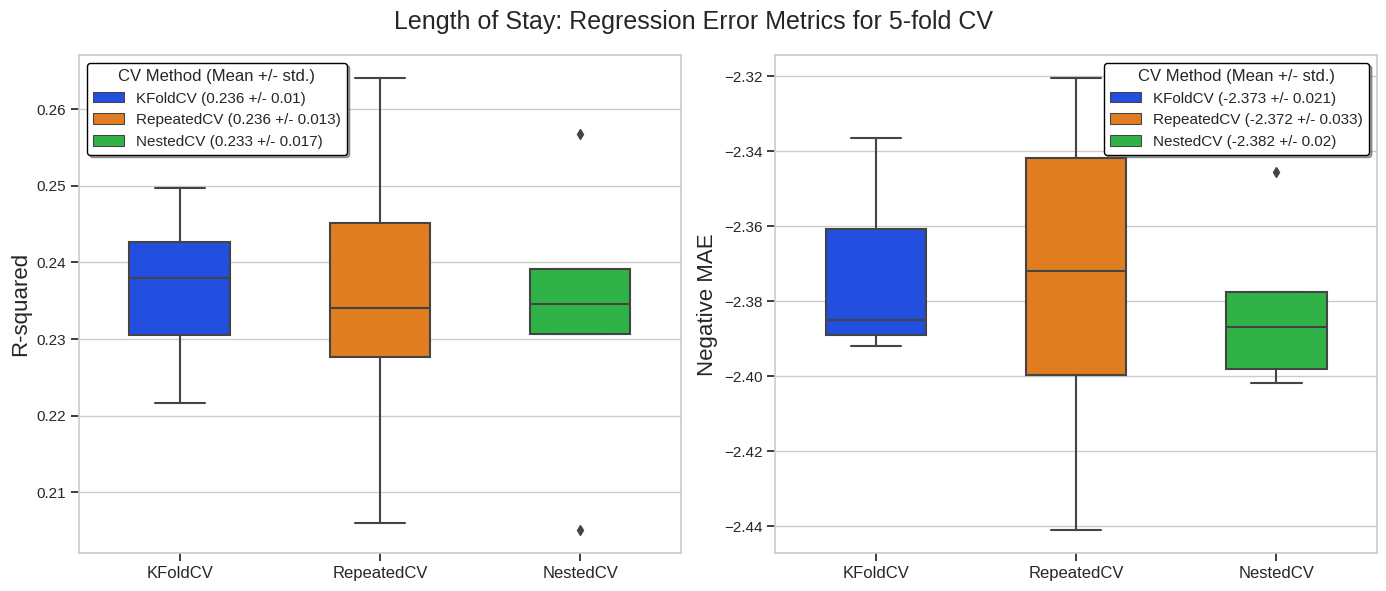

In [10]:
# plot neg_mean_absolute_error/AUPR results from 5-fold CV
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
#plt.style.use('bmh')
sns.set_palette('bright')
sns.set_context('notebook')
plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.boxplot(data=plot_cv_results, x='method', y='test_r2', hue='r2_label', dodge=False,
            width=0.5, whis=1.5)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=12)
plt.xlabel('')
plt.ylabel('R-squared', size=16)
plt.subplot(122)
sns.boxplot(data=plot_cv_results, x='method', y='test_neg_mean_absolute_error',
            hue='neg_mean_absolute_error_label', dodge=False, width=0.5, whis=1.5)
plt.legend(frameon=True, edgecolor='black', shadow=True, fontsize=11, title='CV Method (Mean +/- std.)',
           facecolor='white')
plt.xticks(size=12)
plt.xlabel('')
plt.ylabel('Negative MAE', size=16)
plt.suptitle('Length of Stay: Regression Error Metrics for 5-fold CV', size=18)
plt.tight_layout(True)
plt.savefig('../plots/LOS_PREDICTION_RSQUARED_NEGATIVE_MAE_BOXPLOTS_5_FOLD_CV.png', dpi=300)
plt.show();

## Experiment 2: Estimate of True Test Error

- Define 20% validation set and run CV on remaining 80% <br>
- Run CV with different methods and return best estimators <br>
- Predict on validation set with best CV estimator and compare results to within-CV metrics

In [11]:
# split data into separate validation set (use to estimate true test error)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=8888, shuffle=True,
                                                  test_size=0.2)

# examine training dataset (to use with CV) and validation dataset
X_train.head()
X_train.shape
y_train.head()
y_train.shape
y_train.mean()

X_val.head()
X_val.shape
y_val.head()
y_val.shape
y_val.mean()

,AGE,ETHNICITY_NUM,GENDER_NUM,HEIGHT,WEIGHT,Septicemia (except in labor),Diabetes mellitus without complication,Diabetes mellitus with complications,Disorders of lipid metabolism,Fluid and electrolyte disorders,...,CEREBROVASCULAR ACCIDENT,SEPSIS,HYPOXIA,RESPIRATORY DISTRESS,GENDER_MALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN
34037,66.537988,4,2,180.8,75.940847,0,1,0,1,0,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0
13104,69.930185,2,1,162.6,66.320597,1,0,0,0,1,...,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0
19954,64.145106,4,2,175.8,85.000000,0,0,0,0,0,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0
5745,23.953457,4,2,171.8,78.400002,0,0,0,0,1,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0
8472,299.994524,4,2,177.8,92.300003,0,0,0,0,1,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0


(33333, 43)

34037     1.2754
13104     1.0639
19954     7.3681
5745     28.0952
8472     22.6187
Name: LOS_STAY_LABEL, dtype: float64

(33333,)

3.6122747067470673

,AGE,ETHNICITY_NUM,GENDER_NUM,HEIGHT,WEIGHT,Septicemia (except in labor),Diabetes mellitus without complication,Diabetes mellitus with complications,Disorders of lipid metabolism,Fluid and electrolyte disorders,...,CEREBROVASCULAR ACCIDENT,SEPSIS,HYPOXIA,RESPIRATORY DISTRESS,GENDER_MALE,RACE_WHITE,RACE_HISPANIC,RACE_BLACK,RACE_ASIAN,RACE_OTHER_UNKNOWN
17115,61.002053,4,1,165.0,80.013629,1,0,0,0,0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
41042,66.962355,4,2,177.8,135.000000,1,1,0,0,0,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0
39620,69.117043,4,1,160.0,75.240000,0,0,0,0,1,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
10090,299.997262,4,2,169.8,67.400002,1,0,0,1,0,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0
22573,47.813826,0,1,165.8,102.000000,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


(8334, 43)

17115     4.7146
41042    12.8097
39620     1.1982
10090     3.1028
22573     1.7125
Name: LOS_STAY_LABEL, dtype: float64

(8334,)

3.6721397648188145

In [12]:
# define methods to use for cross validation
kf = KFold(n_splits=5, shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True)
loo = LeaveOneOut() # Note: LOOCV runs ~35,000 times with this dataset
repeated_kf = RepeatedKFold(n_repeats=10, n_splits=5)
repeated_skf = RepeatedStratifiedKFold(n_repeats=10, n_splits=5,)

#cv_methods = [kf, skf, loo, repeated_kf, repeated_skf]
#cv_names = ['KFold', 'StratifiedKFold', 'LeaveOneOut', 'RepeatedKFold', 'RepeatedStratifiedKFold']
cv_methods = [kf, repeated_kf]
cv_names = ['KFold', 'RepeatedKFold']
cv_types = dict(zip(cv_names, cv_methods))

clf = GradientBoostingRegressor(n_estimators=50)
cv_dict = {}
cv_dfs = []
cv_run_times = []
cv_types = dict(zip(cv_names, cv_methods))
for name, split_fn in cv_types.items():
    print(name)
    start_time = time()
    cv = cross_validate(clf, X_train, y_train, cv=split_fn, verbose=True, n_jobs=-1,
                        scoring=['r2', 'neg_mean_absolute_error'], return_estimator=True,
                        return_train_score=True)
    total_time = time() - start_time
    cv['total_runtime'] = total_time
    cv_run_times.append(total_time)
    cv_dict[name] = cv
    df = pd.DataFrame(cv)
    df['method'] = name
    cv_dfs.append(df)

KFold


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedKFold


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.9s finished


In [13]:
nested_cv_results = nested_cv(X_train, y_train)
nested_cv_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


OUTER FOLD 5:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished



TOTAL RUNTIME (s): 13.511959075927734


{'estimator': [SVR(C=10.0, gamma=0.1, max_iter=100),
  SVR(C=10.0, gamma=0.1, max_iter=100),
  SVR(C=10.0, gamma=0.1, max_iter=100),
  SVR(C=10.0, gamma=0.1, max_iter=100),
  SVR(C=10.0, gamma=0.1, max_iter=100)],
 'test_r2': [-6.576555557798913,
  -5.5421885211952535,
  -4.709294255586207,
  -6.492373097362496,
  -6.725291509939941],
 'test_neg_mean_absolute_error': [-13.31240934460354,
  -13.141027658791765,
  -13.215342989446588,
  -13.22761577408711,
  -13.674582459831516],
 'total_runtime': 13.511959075927734}

In [14]:
# view results
cv_dict['NestedCV'] = nested_cv_results
cv_dict

nested_cv_df = pd.DataFrame(nested_cv_results)
cols = list(cv_dfs[0].columns)
for col in cols:
    if col not in nested_cv_df.columns:
        if col=='method':
            nested_cv_df[col] = 'NestedCV'
        else:
            nested_cv_df[col] = np.nan
nested_cv_df = nested_cv_df[cols]
cv_dfs.append(nested_cv_df)
cv_results = pd.concat(cv_dfs)
cv_results

{'KFold': {'fit_time': array([4.13238907, 3.98942518, 4.45006156, 4.36081958, 4.20255375]),
  'score_time': array([0.03207135, 0.05145836, 0.04490876, 0.03659558, 0.0351491 ]),
  'estimator': [GradientBoostingRegressor(n_estimators=50),
   GradientBoostingRegressor(n_estimators=50),
   GradientBoostingRegressor(n_estimators=50),
   GradientBoostingRegressor(n_estimators=50),
   GradientBoostingRegressor(n_estimators=50)],
  'test_r2': array([0.23661467, 0.24423687, 0.21819203, 0.23691196, 0.24339147]),
  'train_r2': array([0.25927943, 0.25575194, 0.26426567, 0.25896656, 0.25743552]),
  'test_neg_mean_absolute_error': array([-2.32814757, -2.3885874 , -2.36394391, -2.32196998, -2.43651285]),
  'train_neg_mean_absolute_error': array([-2.35508912, -2.33402319, -2.33563678, -2.3656506 , -2.31854081]),
  'total_runtime': 4.98027229309082},
 'RepeatedKFold': {'fit_time': array([ 9.62048459, 10.63824797,  8.9460988 ,  9.28392386,  9.09473538,
         10.12507963, 10.43476009,  8.98220825,  9.

,fit_time,score_time,estimator,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error,total_runtime,method
0,4.132389,0.032071,([DecisionTreeRegressor(criterion='friedman_ms...,0.236615,0.259279,-2.328148,-2.355089,4.980272,KFold
1,3.989425,0.051458,([DecisionTreeRegressor(criterion='friedman_ms...,0.244237,0.255752,-2.388587,-2.334023,4.980272,KFold
2,4.450062,0.044909,([DecisionTreeRegressor(criterion='friedman_ms...,0.218192,0.264266,-2.363944,-2.335637,4.980272,KFold
3,4.360820,0.036596,([DecisionTreeRegressor(criterion='friedman_ms...,0.236912,0.258967,-2.321970,-2.365651,4.980272,KFold
4,4.202554,0.035149,([DecisionTreeRegressor(criterion='friedman_ms...,0.243391,0.257436,-2.436513,-2.318541,4.980272,KFold
0,9.620485,0.073243,([DecisionTreeRegressor(criterion='friedman_ms...,0.224356,0.261805,-2.262123,-2.376369,21.025455,RepeatedKFold
1,10.638248,0.054749,([DecisionTreeRegressor(criterion='friedman_ms...,0.232867,0.261485,-2.379065,-2.335693,21.025455,RepeatedKFold
2,8.946099,0.088056,([DecisionTreeRegressor(criterion='friedman_ms...,0.228066,0.260681,-2.357988,-2.346005,21.025455,RepeatedKFold
3,9.283924,0.076494,([DecisionTreeRegressor(criterion='friedman_ms...,0.249725,0.253640,-2.399327,-2.332532,21.025455,RepeatedKFold
4,9.094735,0.068645,([DecisionTreeRegressor(criterion='friedman_ms...,0.239715,0.257299,-2.436464,-2.319901,21.025455,RepeatedKFold


In [15]:
from sklearn.metrics import average_precision_score, roc_auc_score

# get best model over folds for each CV approach
cv_names.append('NestedCV')
val_dict = {}
val_nmaes = []
val_r2s = []
for cv_method in cv_names:
    cv_nmaes = cv_dict[cv_method]['test_neg_mean_absolute_error']
    cv_r2s = cv_dict[cv_method]['test_r2']
    cv_models = cv_dict[cv_method]['estimator']
    best_nmae = np.max(cv_nmaes)
    best_r2 = np.max(cv_r2s)
    best_clf = cv_models[np.argmax(cv_nmaes)]
    
    # predict on validation set using best model from CV
    y_pred = best_clf.predict(X_val)
    val_nmae = -1*mean_absolute_error(y_val, y_pred)
    val_r2 = r2_score(y_val, y_pred)
    val_nmaes.append(val_nmae)
    val_r2s.append(val_r2)
    
    # get metrics and save as dict
    val_dict[cv_method] = {}
    val_dict[cv_method]['CV_Best_nmae'] = best_nmae
    val_dict[cv_method]['CV_Best_r2'] = best_r2
    val_dict[cv_method]['Val_nmae'] = val_nmae
    val_dict[cv_method]['Val_r2'] = val_r2
    val_dict[cv_method]['Val_Relative_CV_nmae'] =  val_nmae / best_nmae
    val_dict[cv_method]['Val_Relative_CV_r2'] = val_r2 / best_r2
    val_dict[cv_method]['Val_Relative_Avg_CV_nmae'] =  val_nmae / np.mean(cv_nmaes)
    val_dict[cv_method]['Val_Relative_Avg_CV_r2'] = val_r2 / np.mean(cv_r2s)

In [16]:
# view results
val_df = pd.DataFrame(val_dict)
val_df

,KFold,RepeatedKFold,NestedCV
CV_Best_nmae,-2.321970,-2.262123,-13.141028
CV_Best_r2,0.244237,0.269847,-4.709294
Val_nmae,-2.383323,-2.385423,-13.061969
Val_r2,0.230377,0.229042,-5.918666
Val_Relative_CV_nmae,1.026423,1.054506,0.993984
Val_Relative_CV_r2,0.943254,0.848785,1.256805
Val_Relative_Avg_CV_nmae,1.006542,1.008134,0.981056
Val_Relative_Avg_CV_r2,0.976716,0.969113,0.984944


In [17]:
# define function to repeat CV experiments with optional parameters
def apply_cross_validation(X, y, model='GBM', n_folds=5, n_repeats=10,
                           verbose=True):
    # define methods to use for cross validation
    kf = KFold(n_splits=n_folds, shuffle=True)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    #loo = LeaveOneOut() # Note: LOOCV runs ~35,000 times with this dataset
    repeated_kf = RepeatedKFold(n_repeats=n_repeats, n_splits=n_folds)
    repeated_skf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_folds)
    cv_methods = [kf, repeated_kf]
    cv_names = ['KFold', 'RepeatedKFold']
    cv_types = dict(zip(cv_names, cv_methods))
    
    # specify classifier to use
    if model == 'GBM':
        clf = GradientBoostingRegressor(n_estimators=50, )
    elif model == 'SVR':
        clf = SVR()
    else:
        print('Error: Must specify one of the acceptable classifiers (GBM or Support Vector Machine)')
        return
    
    # run through cv methods and store results
    cv_dict = {}
    cv_dfs = []
    cv_run_times = []
    for name, split_fn in cv_types.items():
        print(name)
        start_time = time()
        cv = cross_validate(clf, X, y, cv=split_fn, verbose=verbose, n_jobs=-1,
                            scoring=['r2', 'neg_mean_absolute_error'],
                            return_estimator=True, return_train_score=True)
        cv_dict[name] = cv
        df = pd.DataFrame(cv)
        df['method'] = name
        cv_dfs.append(df)
        total_time = time() - start_time
        cv_run_times.append(total_time)
        cv_dict[name]['total_runtime'] = total_time
    return cv_dict

In [18]:
# function for comparing CV and validation set metrics
def compare_cv_validation_metrics(cv_dict, X_val, y_val):
    val_dict = {}
    val_auprs = []
    val_aurocs = []
    for cv_method in list(cv_dict.keys()):
        run_time = cv_dict[cv_method]['total_runtime']
        cv_nmaes = cv_dict[cv_method]['test_neg_mean_absolute_error']
        cv_r2s = cv_dict[cv_method]['test_r2']
        cv_models = cv_dict[cv_method]['estimator']
        best_nmae = np.max(cv_nmaes)
        best_r2 = np.max(cv_r2s)
        best_clf = cv_models[np.argmax(cv_nmaes)]

        # predict on validation set using best model from CV
        y_pred = best_clf.predict(X_val)
        val_nmae = -1*mean_absolute_error(y_val, y_pred)
        val_r2 = r2_score(y_val, y_pred)
        val_nmaes.append(val_nmae)
        val_r2s.append(val_r2)

        # get metrics and save as dict
        val_dict[cv_method] = {}
        val_dict[cv_method]['Runtime'] = run_time
        val_dict[cv_method]['CV_Best_nmae'] = best_nmae
        val_dict[cv_method]['CV_Best_r2'] = best_r2
        val_dict[cv_method]['Val_nmae'] = val_nmae
        val_dict[cv_method]['Val_r2'] = val_r2
        val_dict[cv_method]['Val_Relative_CV_nmae'] =  val_nmae / best_nmae
        val_dict[cv_method]['Val_Relative_CV_r2'] = val_r2 / best_r2
        val_dict[cv_method]['Val_Relative_Avg_CV_nmae'] =  val_nmae / np.mean(cv_nmaes)
        val_dict[cv_method]['Val_Relative_Avg_CV_r2'] = val_r2 / np.mean(cv_r2s)
    
    # return final metrics as dictionary
    return val_dict

In [19]:
# repeat CV & validation set comparison over different number of folds
val_result_dfs = []
for k in np.arange(2, 11, 1):
    cv_results = apply_cross_validation(X_train, y_train, n_folds=k)
    val_metrics = compare_cv_validation_metrics(cv_results, X_val, y_val)
    val_df = pd.DataFrame(val_metrics)
    val_df['n_folds'] = k
    val_result_dfs.append(val_df)

KFold


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedKFold


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    3.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.0s finished


KFold


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedKFold


[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:    5.8s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


KFold


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedKFold


[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    8.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


KFold


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedKFold


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


KFold


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedKFold


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


KFold


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedKFold


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


KFold


[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    3.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


RepeatedKFold


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


KFold


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    3.2s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.4s finished


RepeatedKFold


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


KFold


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


RepeatedKFold


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.6s finished


In [20]:
# repeat CV & validation set comparison over different number of folds
nested_cv_result_dfs = []
nested_cv_result_dicts = []
nested_cv_val_dfs = []
for k in np.arange(2, 11, 1):
    nested_cv_results = nested_cv(X_train, y_train, n_folds=k)
    nested_cv_result_dicts.append(nested_cv_results)
    nested_cv_result_df = pd.DataFrame(nested_cv_results)
    nested_cv_result_df['n_folds'] = k
    nested_cv_result_dfs.append(pd.DataFrame(nested_cv_result_df))
    
    nested_cv_dict = {}
    nested_cv_dict['NestedCV'] = nested_cv_results
    nested_cv_val_metrics = compare_cv_validation_metrics(nested_cv_dict, X_val, y_val)
    nested_cv_val_df = pd.DataFrame(nested_cv_val_metrics)
    nested_cv_val_df['n_folds'] = k
    nested_cv_val_dfs.append(nested_cv_val_df)
nested_cv_val_results = pd.concat(nested_cv_val_dfs)

OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.9s finished



TOTAL RUNTIME (s): 3.2169814109802246
OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished



TOTAL RUNTIME (s): 5.670422792434692
OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.5s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.6s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.6s finished


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.6s finished



TOTAL RUNTIME (s): 7.990715026855469
OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


OUTER FOLD 5:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished



TOTAL RUNTIME (s): 11.058270454406738
OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.0s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.0s finished


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s finished


OUTER FOLD 5:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s finished


OUTER FOLD 6:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s finished



TOTAL RUNTIME (s): 13.650043725967407
OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.1s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.1s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.0s finished


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.1s finished


OUTER FOLD 5:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.1s finished


OUTER FOLD 6:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.1s finished


OUTER FOLD 7:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.0s finished



TOTAL RUNTIME (s): 16.76044535636902
OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.3s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished


OUTER FOLD 5:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.2s finished


OUTER FOLD 6:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished


OUTER FOLD 7:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.3s finished


OUTER FOLD 8:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.1s finished



TOTAL RUNTIME (s): 19.60412311553955
OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.2s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.0s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.3s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.2s finished


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.3s finished


OUTER FOLD 5:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.2s finished


OUTER FOLD 6:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.3s finished


OUTER FOLD 7:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.2s finished


OUTER FOLD 8:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.1s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.3s finished


OUTER FOLD 9:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.2s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.2s finished



TOTAL RUNTIME (s): 22.82921051979065
OUTER FOLD 1:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished


OUTER FOLD 2:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished


OUTER FOLD 3:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


OUTER FOLD 4:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


OUTER FOLD 5:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished


OUTER FOLD 6:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


OUTER FOLD 7:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


OUTER FOLD 8:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


OUTER FOLD 9:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished


OUTER FOLD 10:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished



TOTAL RUNTIME (s): 25.824825763702393


In [21]:
# combine results from NestedCV and other CV methods
val_results = pd.concat(val_result_dfs)
val_results = val_results.reset_index().rename(columns={'index':'Metric'})
nested_cv_val = nested_cv_val_results.reset_index().rename(columns={'index':'Metric'}).sort_values(by=['n_folds', 'Metric'])
cv_val_results = val_results.sort_values(by=['n_folds', 'Metric']).merge(nested_cv_val, on=['n_folds', 'Metric'])

# examine final metrics over parameter values
plot_val = cv_val_results.reset_index(drop=True)
plot_val_r2 = plot_val[plot_val.Metric=='Val_Relative_CV_r2'].reset_index(drop=True)
plot_val_nmae = plot_val[plot_val.Metric=='Val_Relative_CV_nmae'].reset_index(drop=True)
plot_val_time = plot_val[plot_val.Metric=='Runtime'].reset_index(drop=True)
plot_val

,Metric,KFold,RepeatedKFold,n_folds,NestedCV
0,CV_Best_nmae,-2.355390,-2.329669,2,-8.945648
1,CV_Best_r2,0.237303,0.244889,2,-2.201704
2,Runtime,2.394336,4.077976,2,3.216981
3,Val_Relative_Avg_CV_nmae,1.008128,1.006649,2,0.973228
4,Val_Relative_Avg_CV_r2,0.967325,0.970137,2,0.971451
...,...,...,...,...,...
76,Val_Relative_Avg_CV_r2,0.976031,0.969557,10,0.971355
77,Val_Relative_CV_nmae,1.036550,1.073629,10,0.996896
78,Val_Relative_CV_r2,0.856080,0.769125,10,1.273476
79,Val_nmae,-2.372478,-2.378106,10,-14.153322


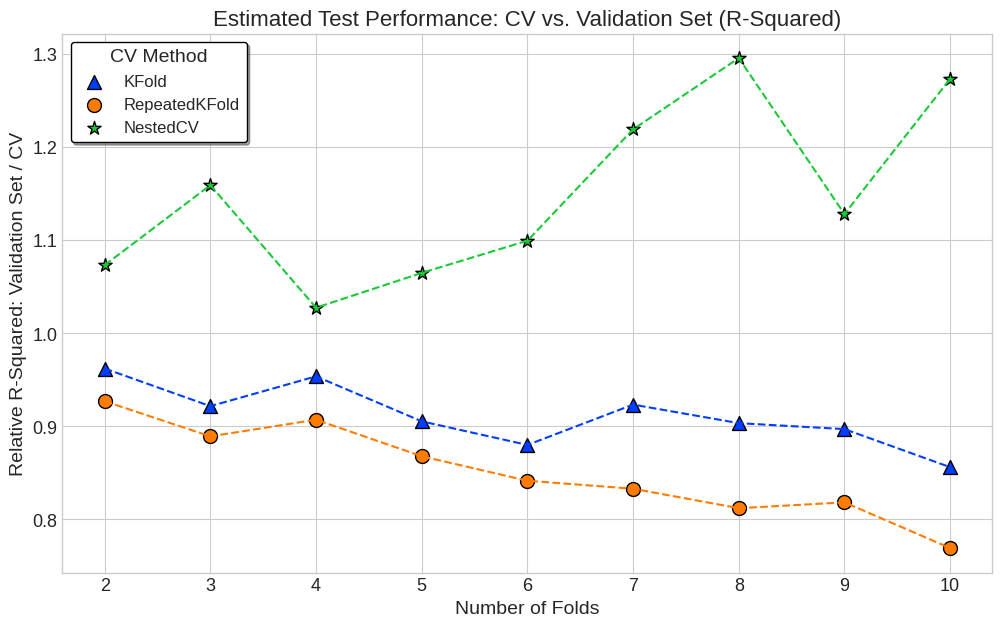

In [22]:
# plot validation relative to CV AUPR by number of folds
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
#plt.style.use(['science','notebook'])
plt.figure(figsize=(12,7))

plt.scatter(plot_val_r2.n_folds, plot_val_r2.KFold, label='KFold', edgecolors='k', marker="^", s=100)
plt.plot(plot_val_r2.n_folds, plot_val_r2.KFold, linestyle='--')

plt.scatter(plot_val_r2.n_folds, plot_val_r2.RepeatedKFold, label='RepeatedKFold', edgecolors='k', marker='o', s=100)
plt.plot(plot_val_r2.n_folds, plot_val_r2.RepeatedKFold, linestyle='--')

plt.scatter(plot_val_r2.n_folds, plot_val_r2.NestedCV, label='NestedCV', edgecolors='k', marker='*', s=100)
plt.plot(plot_val_r2.n_folds, plot_val_r2.NestedCV, linestyle='--')

plt.ylabel('Relative R-Squared: Validation Set / CV', size=14)
plt.xlabel('Number of Folds', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('Estimated Test Performance: CV vs. Validation Set (R-Squared)', size=16)
plt.legend(fontsize=12, title='CV Method', title_fontsize=14, frameon=True, edgecolor='black', shadow=True, facecolor='white')
#plt.tight_layout()
plt.savefig('../plots/LOS_PREDICTION_VALIDATION_RELATIVE_CV_RSQUARED_BY_FOLDS_LINEPLOT.png', dpi=300)
plt.show();

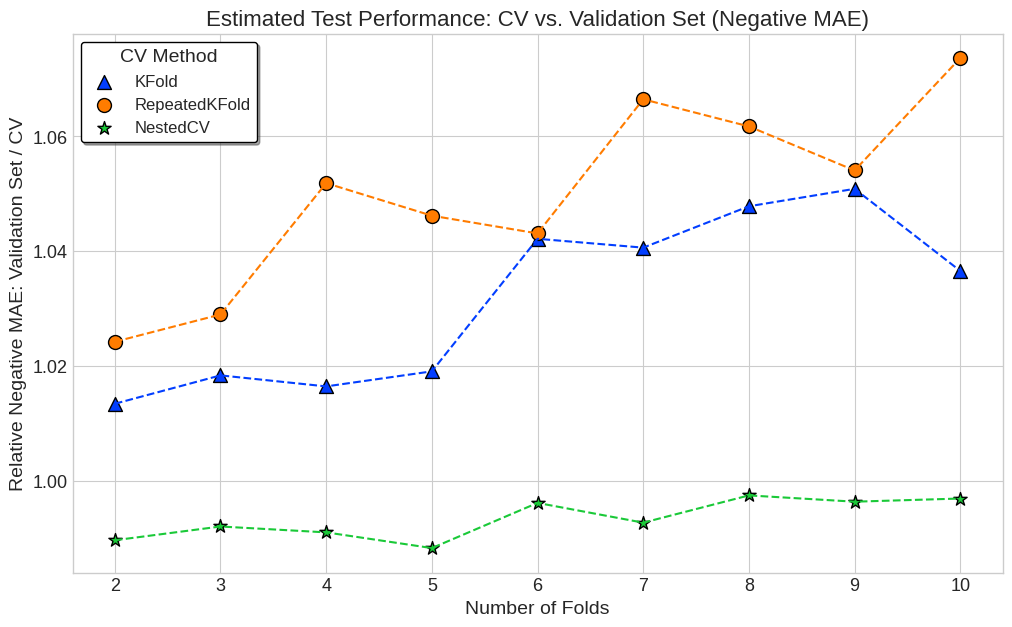

In [23]:
# plot validation relative to CV AUROC by number of folds
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
#plt.style.use(['science','notebook'])
plt.figure(figsize=(12,7))

plt.scatter(plot_val_nmae.n_folds, plot_val_nmae.KFold, label='KFold', edgecolors='k', marker="^", s=100)
plt.plot(plot_val_nmae.n_folds, plot_val_nmae.KFold, linestyle='--')

plt.scatter(plot_val_nmae.n_folds, plot_val_nmae.RepeatedKFold, label='RepeatedKFold', edgecolors='k', marker='o', s=100)
plt.plot(plot_val_nmae.n_folds, plot_val_nmae.RepeatedKFold, linestyle='--')

plt.scatter(plot_val_nmae.n_folds, plot_val_nmae.NestedCV, label='NestedCV', edgecolors='k', marker='*', s=100)
plt.plot(plot_val_nmae.n_folds, plot_val_nmae.NestedCV, linestyle='--')

plt.ylabel('Relative Negative MAE: Validation Set / CV', size=14)
plt.xlabel('Number of Folds', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('Estimated Test Performance: CV vs. Validation Set (Negative MAE)', size=16)
plt.legend(fontsize=12, title='CV Method', title_fontsize=14, frameon=True, edgecolor='black', shadow=True, facecolor='white')
#plt.tight_layout()
plt.savefig('../plots/LOS_VALIDATION_RELATIVE_CV_NEGATIVE_MAE_BY_FOLDS_LINEPLOT.png', dpi=300)
plt.show();

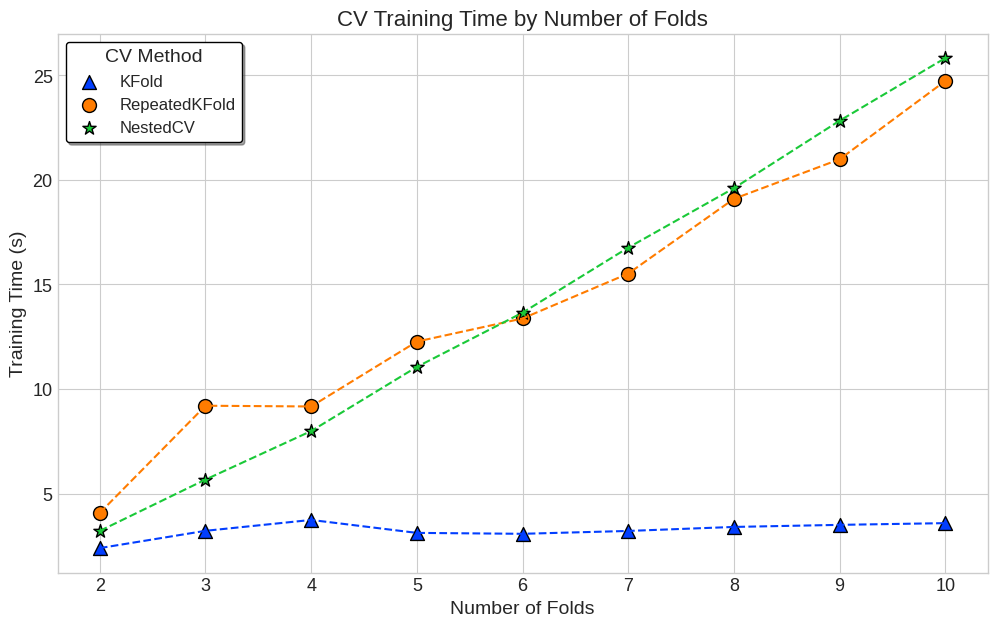

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/wilimid/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

In [24]:
# plot total training runtime from CV by number of folds
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
sns.set_palette('bright')
#plt.style.use(['science','notebook'])
plt.figure(figsize=(12,7))

plt.scatter(plot_val_time.n_folds, plot_val_time.KFold, label='KFold', edgecolors='k', marker="^", s=100)
plt.plot(plot_val_time.n_folds, plot_val_time.KFold, linestyle='--')

plt.scatter(plot_val_time.n_folds, plot_val_time.RepeatedKFold, label='RepeatedKFold', edgecolors='k', marker='o', s=100)
plt.plot(plot_val_time.n_folds, plot_val_time.RepeatedKFold, linestyle='--')

plt.scatter(plot_val_time.n_folds, plot_val_time.NestedCV, label='NestedCV', edgecolors='k', marker='*', s=100)
plt.plot(plot_val_time.n_folds, plot_val_time.NestedCV, linestyle='--')

plt.ylabel('Training Time (s)', size=14)
plt.xlabel('Number of Folds', size=14)
plt.xticks(size=13)
plt.yticks(size=13)
plt.title('CV Training Time by Number of Folds', size=16)
plt.legend(fontsize=12, title='CV Method', title_fontsize=14, frameon=True, edgecolor='black', shadow=True, facecolor='white')
#plt.tight_layout()
plt.savefig('../plots/LOS_VALIDATION_CV_TRAINING_TIME_BY_FOLDS_LINEPLOT.png', dpi=300)
plt.show();